In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
/kaggle/input/00-churndata-preprocessing/__results__.html
/kaggle/input/00-churndata-preprocessing/__notebook__.ipynb
/kaggle/input/00-churndata-preprocessing/__output__.json
/kaggle/input/00-churndata-preprocessing/custom.css
/kaggle/input/00-churndata-preprocessing/figure/churn_vs.png
/kaggle/input/00-churndata-preprocessing/figure/churn_distribution.png
/kaggle/input/00-churndata-preprocessing/__results___files/__results___6_1.png
/kaggle/input/00-churndata-preprocessing/__results___files/__results___4_0.png
/kaggle/input/00-churndata-preprocessing/processed/orig.csv
/kaggle/input/00-churndata-preprocessing/processed/processed.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
FIG_PATH = 'figures'
os.makedirs(FIG_PATH, exist_ok=True)

In [4]:
df = pd.read_csv('/kaggle/input/00-churndata-preprocessing/processed/processed.csv')
df.head()

,Unnamed: 0,tenure,PhoneService,MultipleLines,PaperlessBilling,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,No phone service,1,Month-to-month,Electronic check,29.85,29.85,0
1,1,34,1,No,0,One year,Mailed check,56.95,1889.50,0
2,2,2,1,No,1,Month-to-month,Mailed check,53.85,108.15,1
3,3,45,0,No phone service,0,One year,Bank transfer (automatic),42.30,1840.75,0
4,4,2,1,No,1,Month-to-month,Electronic check,70.70,151.65,1


In [5]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Unnamed: 0,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,29.85,29.85,0,True,False,False,False,False,True,False
1,1,34,1,0,56.95,1889.50,0,False,False,True,False,False,False,True
2,2,2,1,1,53.85,108.15,1,False,False,False,False,False,False,True
3,3,45,0,0,42.30,1840.75,0,True,False,True,False,False,False,False
4,4,2,1,1,70.70,151.65,1,False,False,False,False,False,True,False


In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['Churn', 'Unnamed: 0'], axis=1)
X.head()
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)

(5634, 12) (1409, 12)


<h2>1. Function (Train and Results)</h2>

In [17]:
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                            precision_recall_fscore_support, roc_auc_score)
from sklearn.base import clone
import numpy as np

def evaluate_model(model, prefix, X_train, X_test, y_train, y_test, plot_cm=False):
    
    estimate = clone(model)
    estimate.fit(X_train, y_train)
    y_pred = estimate.predict(X_test)

    try:
        y_score = estimate.predict_prob(X_test)[:, 1] # get only churn
        auc = roc_auc_score(y_test, y_score)
    except:
        y_score = None
        auc = None

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    print(f"{prefix} Results:\n")
    print(f"\n[{prefix}] Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}", (f"  ROC-AUC={auc:.4f}" if auc is not None else ""))

    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)


    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"], 
                    annot_kws={'size': 14})
        plt.title(f"{prefix} - Confusion Matrix Plot", fontsize=16)
        plt.ylabel("True", fontsize=14); plt.xlabel("Predicted", fontsize=14)
        plt.tick_params(axis='both', labelsize=14)
        plt.tight_layout()
        plt.savefig(f"figures/{prefix}.png", dpi=200, bbox_inches='tight')
        plt.show()

    return

<h2>2. RandomForest</h2>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def build_rf():
    return RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )

RandomForest Results:


[RandomForest] Acc=0.7850  Prec=0.5899  Rec=0.6230  F1=0.6060 

Classification Report:
               precision    recall  f1-score   support

           0     0.8609    0.8435    0.8521      1035
           1     0.5899    0.6230    0.6060       374

    accuracy                         0.7850      1409
   macro avg     0.7254    0.7332    0.7291      1409
weighted avg     0.7890    0.7850    0.7868      1409


Confusion Matrix:
 [[873 162]
 [141 233]]


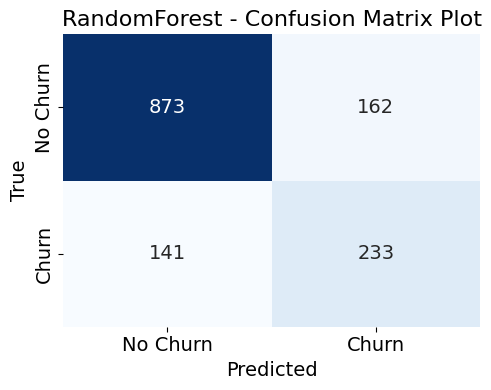

In [19]:
rf  = build_rf()

_ = evaluate_model(rf,  "RandomForest", X_train, X_test, y_train, y_test, plot_cm=True)

<h2>2. XGBoost</h2>

In [ ]:
from xgboost import XGBClassifier


pos = y_train.sum()
neg = len(y_train) - pos
scale_pos = neg / pos if pos > 0 else 1.0  # For XGBoost

def build_xgb():
    return XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        n_jobs=-1,
        random_state=42,
        tree_method="gpu_hist",
        eval_metric="logloss",
        scale_pos_weight=scale_pos
    )

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [22:43:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [22:43:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Results:


[XGBoost] Acc=0.7559  Prec=0.5293  Rec=0.7246  F1=0.6117 

Classification Report:
               precision    recall  f1-score   support

           0     0.8852    0.7671    0.8219      1035
           1     0.5293    0.7246    0.6117       374

    accuracy                         0.7559      1409
   macro avg     0.7072    0.7459    0.7168      1409
weighted avg     0.7907    0.7559    0.7661      1409


Confusion Matrix:
 [[794 241]
 [103 271]]


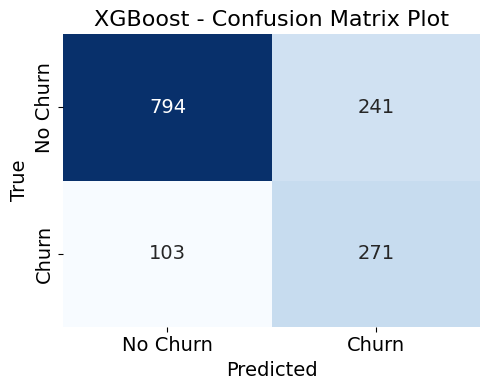

In [23]:
xgb = build_xgb()

_ = evaluate_model(xgb, "XGBoost", X_train, X_test, y_train, y_test, plot_cm=True)

<h2>3. LightGBM</h2>

In [26]:
from lightgbm import LGBMClassifier
def build_lgbm():
    return LGBMClassifier(
        n_estimators=500,
        num_leaves=31,
        learning_rate=0.08,
        min_child_samples=40,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary",
        n_jobs=-1,
        device="gpu",
        random_state=42,
        eval_metric="binary_logloss",
        scale_pos_weight=scale_pos
    )

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (0.04 MB) transferred to GPU in 0.000570 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Unknown parameter: eval_metric
LightGBM Results:


[LightGBM] Acc=0.7580  Prec=0.5337  Rec=0.6979  F1=0.6049 

Classification Report:
               precision    recall  f1-score   support

           0     0.8772    0.7797    0.8256      1035
           1     0.5337    0.6979    0.6049       374

    accuracy                         0.7580      1409
   macro avg     0.7055    0.7388    0.7152      1409
weighted avg     0.7860    0.7580    0.7670      1409


Confusion Matrix:
 [[807 228]
 [113 261]]


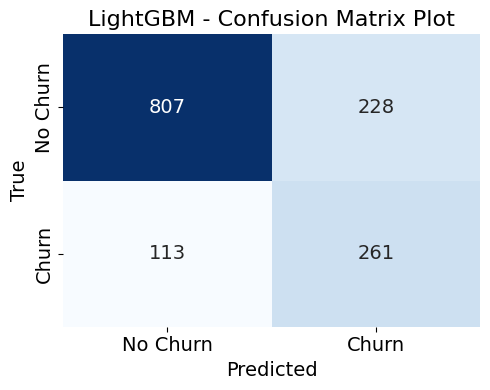

In [27]:
lgbm = build_lgbm()

_ = evaluate_model(lgbm, "LightGBM", X_train, X_test, y_train, y_test, plot_cm=True)

<h2>5. Grid Search - LightGBM</h2>

In [38]:
lgbm = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    device='gpu',
    scale_pos_weight=scale_pos
)

param_grid = {
    'n_estimators': [300, 500],
    'num_leaves': [25, 31, 40],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7]
}

In [39]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=-1
)

In [41]:
# grid_search.fit(X_train, y_train)

In [42]:
# print("Best Parameters: ", grid_search.best_params_)

# print("Best Score (ROC-AUC): ", grid_search.best_score_)

In [43]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)
# print("\nConfusion Matrix:\n", cm)


# plt.figure(figsize=(5, 4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"], 
#             annot_kws={'size': 14})
# plt.title("LightGBM Grid Search - Confusion Matrix Plot", fontsize=16)
# plt.ylabel("True", fontsize=14); plt.xlabel("Predicted", fontsize=14)
# plt.tick_params(axis='both', labelsize=14)
# plt.tight_layout()
# plt.savefig("figures/LightGBM-GridSearch.png", dpi=200, bbox_inches='tight')
# plt.show()